**SLEEP STAGE CLASSIFICATION FROM EEG DATA USING MACHINE LEARNING**

In [1]:
import os

# Base data folder
DATA_ROOT = "/content/data"
SLEEP_EDF_ROOT = os.path.join(DATA_ROOT, "sleep-edfx")
CASSETTE_DIR = os.path.join(SLEEP_EDF_ROOT, "sleep-cassette")

os.makedirs(CASSETTE_DIR, exist_ok=True)

print("DATA_ROOT:", DATA_ROOT)
print("SLEEP_EDF_ROOT:", SLEEP_EDF_ROOT)
print("CASSETTE_DIR:", CASSETTE_DIR)


DATA_ROOT: /content/data
SLEEP_EDF_ROOT: /content/data/sleep-edfx
CASSETTE_DIR: /content/data/sleep-edfx/sleep-cassette


In [2]:
!pip install -q awscli
!aws --version


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sphinx 8.2.3 requires docutils<0.22,>=0.20, but you have docutils 0.19 which is incompatible.
aws-cli/1.44.46 Python/3.12.12 Linux/6.6.113+ botocore/1.42.56


In [3]:
# DOWNLOAD SLEEP-EDF

DATA_ROOT = "/content/data"
SLEEP_EDF_ROOT = f"{DATA_ROOT}/sleep-edfx"
CASSETTE_DIR = f"{SLEEP_EDF_ROOT}/sleep-cassette"

# Create directories
import os
os.makedirs(CASSETTE_DIR, exist_ok=True)

print("Downloading Sleep-EDF (sleep-cassette)...")

!aws s3 sync --no-sign-request \
    s3://physionet-open/sleep-edfx/1.0.0/sleep-cassette/ \
    "$CASSETTE_DIR" \
    --quiet

print("Download completed!")
print("Files in cassette folder:", len(os.listdir(CASSETTE_DIR)))


Download completed!
Files in cassette folder: 306


In [4]:
!ls "$CASSETTE_DIR" | head


SC4001E0-PSG.edf
SC4001EC-Hypnogram.edf
SC4002E0-PSG.edf
SC4002EC-Hypnogram.edf
SC4011E0-PSG.edf
SC4011EH-Hypnogram.edf
SC4012E0-PSG.edf
SC4012EC-Hypnogram.edf
SC4021E0-PSG.edf
SC4021EH-Hypnogram.edf


In [5]:

!pip install mne --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 84.5 MB/s eta 0:00:00


In [6]:
import mne
import numpy as np

stage_map = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4
}

def load_sleep_record(psg_path, hypnogram_path, target_channel="EEG Fpz-Cz"):


    raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)

    if target_channel not in raw.ch_names:
        raise ValueError(f"Channel {target_channel} not found in {psg_path}")

    raw.pick_channels([target_channel])
    sf = int(raw.info["sfreq"])


    raw.filter(0.3, 35., fir_design="firwin", verbose=False)

    annotations = mne.read_annotations(hypnogram_path)
    raw.set_annotations(annotations)

    sleep_ann = [a for a in annotations if a["description"] in stage_map]

    if len(sleep_ann) == 0:
        return np.zeros((0, 1, 1)), np.zeros((0,)), sf

    present_stages = sorted(list(set(a["description"] for a in sleep_ann)))
    event_id = {desc: i for i, desc in enumerate(present_stages)}

    events, _ = mne.events_from_annotations(
        raw, event_id=event_id, verbose=False
    )

    epochs = mne.Epochs(
        raw,
        events,
        event_id=event_id,
        tmin=0.0,
        tmax=30.0 - 1/sf,
        baseline=None,
        preload=True,
        verbose=False
    )

    X = epochs.get_data()

    X = (X - X.mean(axis=-1, keepdims=True)) / \
        (X.std(axis=-1, keepdims=True) + 1e-8)

    event_codes = epochs.events[:, 2]
    id_to_name = {v: k for k, v in event_id.items()}
    y = np.array([stage_map[id_to_name[c]] for c in event_codes])

    valid_mask = (y >= 0) & (y <= 4)
    X = X[valid_mask]
    y = y[valid_mask]

    if len(X) > 20:
        X = X[5:-5]
        y = y[5:-5]

    return X, y, sf


In [7]:
import os

all_files = sorted(os.listdir(CASSETTE_DIR))

psg_files = sorted([f for f in all_files if f.endswith("PSG.edf")])
hyp_files = sorted([f for f in all_files if f.endswith("Hypnogram.edf")])

print(f"Found {len(psg_files)} PSG files")
print(f"Found {len(hyp_files)} Hypnogram files")

print("\nFirst few PSG files:")
print(psg_files[:10])

print("\nFirst few Hypnogram files:")
print(hyp_files[:10])


Found 153 PSG files
Found 153 Hypnogram files

First few PSG files:
['SC4001E0-PSG.edf', 'SC4002E0-PSG.edf', 'SC4011E0-PSG.edf', 'SC4012E0-PSG.edf', 'SC4021E0-PSG.edf', 'SC4022E0-PSG.edf', 'SC4031E0-PSG.edf', 'SC4032E0-PSG.edf', 'SC4041E0-PSG.edf', 'SC4042E0-PSG.edf']

First few Hypnogram files:
['SC4001EC-Hypnogram.edf', 'SC4002EC-Hypnogram.edf', 'SC4011EH-Hypnogram.edf', 'SC4012EC-Hypnogram.edf', 'SC4021EH-Hypnogram.edf', 'SC4022EJ-Hypnogram.edf', 'SC4031EC-Hypnogram.edf', 'SC4032EP-Hypnogram.edf', 'SC4041EC-Hypnogram.edf', 'SC4042EC-Hypnogram.edf']


In [8]:
import numpy as np

subjects = sorted(list(set([f[:7] for f in psg_files])))

print("Total subjects:", len(subjects))
print("Subjects example:", subjects[:10])

np.random.seed(42)
np.random.shuffle(subjects)

split_idx = int(0.8 * len(subjects))
train_subj = set(subjects[:split_idx])
test_subj  = set(subjects[split_idx:])

print("\nTrain subjects:", len(train_subj))
print("Test subjects :", len(test_subj))

X_train_list, y_train_list = [], []
X_test_list,  y_test_list  = [], []

for psg_file in psg_files:
    subj_id = psg_file[:7]
    matching_hyps = [h for h in hyp_files if h.startswith(subj_id)]
    if len(matching_hyps) == 0:
        print(f"No hypnogram found for {psg_file}")
        continue

    hyp_file = matching_hyps[0]
    psg_path = os.path.join(CASSETTE_DIR, psg_file)
    hyp_path = os.path.join(CASSETTE_DIR, hyp_file)

    print(f"\nLoading subject {subj_id}")
    print(f"PSG: {psg_file}")
    print(f"HYP: {hyp_file}")

    X, y, sf = load_sleep_record(psg_path, hyp_path)

    print(f"epochs: {len(X)}, labels: {len(y)}, sampling: {sf} Hz")

    if len(X) == 0:
        print("Skipped (no valid sleep annotations).")
        continue

    if subj_id in train_subj:
        X_train_list.append(X)
        y_train_list.append(y)
    else:
        X_test_list.append(X)
        y_test_list.append(y)

X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
X_test  = np.concatenate(X_test_list,  axis=0)
y_test  = np.concatenate(y_test_list,  axis=0)

print("\n FINAL DATA SHAPES")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test :", X_test.shape)
print("y_test :", y_test.shape)

print("\n Train label distribution:", np.unique(y_train, return_counts=True))
print("Test label distribution :", np.unique(y_test, return_counts=True))


Total subjects: 153
Subjects example: ['SC4001E', 'SC4002E', 'SC4011E', 'SC4012E', 'SC4021E', 'SC4022E', 'SC4031E', 'SC4032E', 'SC4041E', 'SC4042E']

Train subjects: 122
Test subjects : 31

Loading subject SC4001E
PSG: SC4001E0-PSG.edf
HYP: SC4001EC-Hypnogram.edf


/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 143, labels: 143, sampling: 100 Hz

Loading subject SC4002E
PSG: SC4002E0-PSG.edf
HYP: SC4002EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 140, labels: 140, sampling: 100 Hz

Loading subject SC4011E
PSG: SC4011E0-PSG.edf
HYP: SC4011EH-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 115, labels: 115, sampling: 100 Hz

Loading subject SC4012E
PSG: SC4012E0-PSG.edf
HYP: SC4012EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 160, labels: 160, sampling: 100 Hz

Loading subject SC4021E
PSG: SC4021E0-PSG.edf
HYP: SC4021EH-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 150, labels: 150, sampling: 100 Hz

Loading subject SC4022E
PSG: SC4022E0-PSG.edf
HYP: SC4022EJ-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 167, labels: 167, sampling: 100 Hz

Loading subject SC4031E
PSG: SC4031E0-PSG.edf
HYP: SC4031EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 108, labels: 108, sampling: 100 Hz

Loading subject SC4032E
PSG: SC4032E0-PSG.edf
HYP: SC4032EP-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 112, labels: 112, sampling: 100 Hz

Loading subject SC4041E
PSG: SC4041E0-PSG.edf
HYP: SC4041EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 149, labels: 149, sampling: 100 Hz

Loading subject SC4042E
PSG: SC4042E0-PSG.edf
HYP: SC4042EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 163, labels: 163, sampling: 100 Hz

Loading subject SC4051E
PSG: SC4051E0-PSG.edf
HYP: SC4051EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 119, labels: 119, sampling: 100 Hz

Loading subject SC4052E
PSG: SC4052E0-PSG.edf
HYP: SC4052EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 126, labels: 126, sampling: 100 Hz

Loading subject SC4061E
PSG: SC4061E0-PSG.edf
HYP: SC4061EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 67, labels: 67, sampling: 100 Hz

Loading subject SC4062E
PSG: SC4062E0-PSG.edf
HYP: SC4062EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 87, labels: 87, sampling: 100 Hz

Loading subject SC4071E
PSG: SC4071E0-PSG.edf
HYP: SC4071EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 105, labels: 105, sampling: 100 Hz

Loading subject SC4072E
PSG: SC4072E0-PSG.edf
HYP: SC4072EH-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 168, labels: 168, sampling: 100 Hz

Loading subject SC4081E
PSG: SC4081E0-PSG.edf
HYP: SC4081EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 131, labels: 131, sampling: 100 Hz

Loading subject SC4082E
PSG: SC4082E0-PSG.edf
HYP: SC4082EP-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 145, labels: 145, sampling: 100 Hz

Loading subject SC4091E
PSG: SC4091E0-PSG.edf
HYP: SC4091EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 127, labels: 127, sampling: 100 Hz

Loading subject SC4092E
PSG: SC4092E0-PSG.edf
HYP: SC4092EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 93, labels: 93, sampling: 100 Hz

Loading subject SC4101E
PSG: SC4101E0-PSG.edf
HYP: SC4101EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 51, labels: 51, sampling: 100 Hz

Loading subject SC4102E
PSG: SC4102E0-PSG.edf
HYP: SC4102EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 106, labels: 106, sampling: 100 Hz

Loading subject SC4111E
PSG: SC4111E0-PSG.edf
HYP: SC4111EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 114, labels: 114, sampling: 100 Hz

Loading subject SC4112E
PSG: SC4112E0-PSG.edf
HYP: SC4112EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 115, labels: 115, sampling: 100 Hz

Loading subject SC4121E
PSG: SC4121E0-PSG.edf
HYP: SC4121EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 117, labels: 117, sampling: 100 Hz

Loading subject SC4122E
PSG: SC4122E0-PSG.edf
HYP: SC4122EV-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 139, labels: 139, sampling: 100 Hz

Loading subject SC4131E
PSG: SC4131E0-PSG.edf
HYP: SC4131EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 136, labels: 136, sampling: 100 Hz

Loading subject SC4141E
PSG: SC4141E0-PSG.edf
HYP: SC4141EU-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 111, labels: 111, sampling: 100 Hz

Loading subject SC4142E
PSG: SC4142E0-PSG.edf
HYP: SC4142EU-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 113, labels: 113, sampling: 100 Hz

Loading subject SC4151E
PSG: SC4151E0-PSG.edf
HYP: SC4151EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 84, labels: 84, sampling: 100 Hz

Loading subject SC4152E
PSG: SC4152E0-PSG.edf
HYP: SC4152EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 91, labels: 91, sampling: 100 Hz

Loading subject SC4161E
PSG: SC4161E0-PSG.edf
HYP: SC4161EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 140, labels: 140, sampling: 100 Hz

Loading subject SC4162E
PSG: SC4162E0-PSG.edf
HYP: SC4162EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 122, labels: 122, sampling: 100 Hz

Loading subject SC4171E
PSG: SC4171E0-PSG.edf
HYP: SC4171EU-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 171, labels: 171, sampling: 100 Hz

Loading subject SC4172E
PSG: SC4172E0-PSG.edf
HYP: SC4172EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 175, labels: 175, sampling: 100 Hz

Loading subject SC4181E
PSG: SC4181E0-PSG.edf
HYP: SC4181EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 150, labels: 150, sampling: 100 Hz

Loading subject SC4182E
PSG: SC4182E0-PSG.edf
HYP: SC4182EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 97, labels: 97, sampling: 100 Hz

Loading subject SC4191E
PSG: SC4191E0-PSG.edf
HYP: SC4191EP-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 167, labels: 167, sampling: 100 Hz

Loading subject SC4192E
PSG: SC4192E0-PSG.edf
HYP: SC4192EV-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 113, labels: 113, sampling: 100 Hz

Loading subject SC4201E
PSG: SC4201E0-PSG.edf
HYP: SC4201EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 44, labels: 44, sampling: 100 Hz

Loading subject SC4202E
PSG: SC4202E0-PSG.edf
HYP: SC4202EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 36, labels: 36, sampling: 100 Hz

Loading subject SC4211E
PSG: SC4211E0-PSG.edf
HYP: SC4211EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 102, labels: 102, sampling: 100 Hz

Loading subject SC4212E
PSG: SC4212E0-PSG.edf
HYP: SC4212EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 65, labels: 65, sampling: 100 Hz

Loading subject SC4221E
PSG: SC4221E0-PSG.edf
HYP: SC4221EJ-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 153, labels: 153, sampling: 100 Hz

Loading subject SC4222E
PSG: SC4222E0-PSG.edf
HYP: SC4222EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 171, labels: 171, sampling: 100 Hz

Loading subject SC4231E
PSG: SC4231E0-PSG.edf
HYP: SC4231EJ-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 98, labels: 98, sampling: 100 Hz

Loading subject SC4232E
PSG: SC4232E0-PSG.edf
HYP: SC4232EV-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 132, labels: 132, sampling: 100 Hz

Loading subject SC4241E
PSG: SC4241E0-PSG.edf
HYP: SC4241EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 74, labels: 74, sampling: 100 Hz

Loading subject SC4242E
PSG: SC4242E0-PSG.edf
HYP: SC4242EA-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 107, labels: 107, sampling: 100 Hz

Loading subject SC4251E
PSG: SC4251E0-PSG.edf
HYP: SC4251EP-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 71, labels: 71, sampling: 100 Hz

Loading subject SC4252E
PSG: SC4252E0-PSG.edf
HYP: SC4252EU-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 142, labels: 142, sampling: 100 Hz

Loading subject SC4261F
PSG: SC4261F0-PSG.edf
HYP: SC4261FM-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 183, labels: 183, sampling: 100 Hz

Loading subject SC4262F
PSG: SC4262F0-PSG.edf
HYP: SC4262FC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 85, labels: 85, sampling: 100 Hz

Loading subject SC4271F
PSG: SC4271F0-PSG.edf
HYP: SC4271FC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 129, labels: 129, sampling: 100 Hz

Loading subject SC4272F
PSG: SC4272F0-PSG.edf
HYP: SC4272FM-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 158, labels: 158, sampling: 100 Hz

Loading subject SC4281G
PSG: SC4281G0-PSG.edf
HYP: SC4281GC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 109, labels: 109, sampling: 100 Hz

Loading subject SC4282G
PSG: SC4282G0-PSG.edf
HYP: SC4282GC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 79, labels: 79, sampling: 100 Hz

Loading subject SC4291G
PSG: SC4291G0-PSG.edf
HYP: SC4291GA-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 290, labels: 290, sampling: 100 Hz

Loading subject SC4292G
PSG: SC4292G0-PSG.edf
HYP: SC4292GC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 131, labels: 131, sampling: 100 Hz

Loading subject SC4301E
PSG: SC4301E0-PSG.edf
HYP: SC4301EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 113, labels: 113, sampling: 100 Hz

Loading subject SC4302E
PSG: SC4302E0-PSG.edf
HYP: SC4302EV-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 100, labels: 100, sampling: 100 Hz

Loading subject SC4311E
PSG: SC4311E0-PSG.edf
HYP: SC4311EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 129, labels: 129, sampling: 100 Hz

Loading subject SC4312E
PSG: SC4312E0-PSG.edf
HYP: SC4312EM-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 241, labels: 241, sampling: 100 Hz

Loading subject SC4321E
PSG: SC4321E0-PSG.edf
HYP: SC4321EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 44, labels: 44, sampling: 100 Hz

Loading subject SC4322E
PSG: SC4322E0-PSG.edf
HYP: SC4322EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 123, labels: 123, sampling: 100 Hz

Loading subject SC4331F
PSG: SC4331F0-PSG.edf
HYP: SC4331FV-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 110, labels: 110, sampling: 100 Hz

Loading subject SC4332F
PSG: SC4332F0-PSG.edf
HYP: SC4332FC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 102, labels: 102, sampling: 100 Hz

Loading subject SC4341F
PSG: SC4341F0-PSG.edf
HYP: SC4341FA-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 39, labels: 39, sampling: 100 Hz

Loading subject SC4342F
PSG: SC4342F0-PSG.edf
HYP: SC4342FA-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 80, labels: 80, sampling: 100 Hz

Loading subject SC4351F
PSG: SC4351F0-PSG.edf
HYP: SC4351FA-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 142, labels: 142, sampling: 100 Hz

Loading subject SC4352F
PSG: SC4352F0-PSG.edf
HYP: SC4352FV-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 137, labels: 137, sampling: 100 Hz

Loading subject SC4362F
PSG: SC4362F0-PSG.edf
HYP: SC4362FC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 76, labels: 76, sampling: 100 Hz

Loading subject SC4371F
PSG: SC4371F0-PSG.edf
HYP: SC4371FA-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 92, labels: 92, sampling: 100 Hz

Loading subject SC4372F
PSG: SC4372F0-PSG.edf
HYP: SC4372FC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 48, labels: 48, sampling: 100 Hz

Loading subject SC4381F
PSG: SC4381F0-PSG.edf
HYP: SC4381FC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 59, labels: 59, sampling: 100 Hz

Loading subject SC4382F
PSG: SC4382F0-PSG.edf
HYP: SC4382FW-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 94, labels: 94, sampling: 100 Hz

Loading subject SC4401E
PSG: SC4401E0-PSG.edf
HYP: SC4401EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 81, labels: 81, sampling: 100 Hz

Loading subject SC4402E
PSG: SC4402E0-PSG.edf
HYP: SC4402EW-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 155, labels: 155, sampling: 100 Hz

Loading subject SC4411E
PSG: SC4411E0-PSG.edf
HYP: SC4411EJ-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 168, labels: 168, sampling: 100 Hz

Loading subject SC4412E
PSG: SC4412E0-PSG.edf
HYP: SC4412EM-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 185, labels: 185, sampling: 100 Hz

Loading subject SC4421E
PSG: SC4421E0-PSG.edf
HYP: SC4421EA-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 116, labels: 116, sampling: 100 Hz

Loading subject SC4422E
PSG: SC4422E0-PSG.edf
HYP: SC4422EA-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 147, labels: 147, sampling: 100 Hz

Loading subject SC4431E
PSG: SC4431E0-PSG.edf
HYP: SC4431EM-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 99, labels: 99, sampling: 100 Hz

Loading subject SC4432E
PSG: SC4432E0-PSG.edf
HYP: SC4432EM-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 77, labels: 77, sampling: 100 Hz

Loading subject SC4441E
PSG: SC4441E0-PSG.edf
HYP: SC4441EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 125, labels: 125, sampling: 100 Hz

Loading subject SC4442E
PSG: SC4442E0-PSG.edf
HYP: SC4442EV-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 139, labels: 139, sampling: 100 Hz

Loading subject SC4451F
PSG: SC4451F0-PSG.edf
HYP: SC4451FY-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 203, labels: 203, sampling: 100 Hz

Loading subject SC4452F
PSG: SC4452F0-PSG.edf
HYP: SC4452FW-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 209, labels: 209, sampling: 100 Hz

Loading subject SC4461F
PSG: SC4461F0-PSG.edf
HYP: SC4461FA-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 86, labels: 86, sampling: 100 Hz

Loading subject SC4462F
PSG: SC4462F0-PSG.edf
HYP: SC4462FJ-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 103, labels: 103, sampling: 100 Hz

Loading subject SC4471F
PSG: SC4471F0-PSG.edf
HYP: SC4471FA-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 235, labels: 235, sampling: 100 Hz

Loading subject SC4472F
PSG: SC4472F0-PSG.edf
HYP: SC4472FA-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 219, labels: 219, sampling: 100 Hz

Loading subject SC4481F
PSG: SC4481F0-PSG.edf
HYP: SC4481FV-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
epochs: 208, labels: 208, sampling: 100 Hz

Loading subject SC4482F
PSG: SC4482F0-PSG.edf
HYP: SC4482FJ-Hypnogram.edf


/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
epochs: 197, labels: 197, sampling: 100 Hz

Loading subject SC4491G
PSG: SC4491G0-PSG.edf
HYP: SC4491GJ-Hypnogram.edf


/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 138, labels: 138, sampling: 100 Hz

Loading subject SC4492G
PSG: SC4492G0-PSG.edf
HYP: SC4492GJ-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 157, labels: 157, sampling: 100 Hz

Loading subject SC4501E
PSG: SC4501E0-PSG.edf
HYP: SC4501EW-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 73, labels: 73, sampling: 100 Hz

Loading subject SC4502E
PSG: SC4502E0-PSG.edf
HYP: SC4502EM-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 127, labels: 127, sampling: 100 Hz

Loading subject SC4511E
PSG: SC4511E0-PSG.edf
HYP: SC4511EJ-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 84, labels: 84, sampling: 100 Hz

Loading subject SC4512E
PSG: SC4512E0-PSG.edf
HYP: SC4512EW-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 91, labels: 91, sampling: 100 Hz

Loading subject SC4522E
PSG: SC4522E0-PSG.edf
HYP: SC4522EM-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 57, labels: 57, sampling: 100 Hz

Loading subject SC4531E
PSG: SC4531E0-PSG.edf
HYP: SC4531EM-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 195, labels: 195, sampling: 100 Hz

Loading subject SC4532E
PSG: SC4532E0-PSG.edf
HYP: SC4532EV-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 108, labels: 108, sampling: 100 Hz

Loading subject SC4541F
PSG: SC4541F0-PSG.edf
HYP: SC4541FA-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 170, labels: 170, sampling: 100 Hz

Loading subject SC4542F
PSG: SC4542F0-PSG.edf
HYP: SC4542FW-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 236, labels: 236, sampling: 100 Hz

Loading subject SC4551F
PSG: SC4551F0-PSG.edf
HYP: SC4551FC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 100, labels: 100, sampling: 100 Hz

Loading subject SC4552F
PSG: SC4552F0-PSG.edf
HYP: SC4552FW-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 74, labels: 74, sampling: 100 Hz

Loading subject SC4561F
PSG: SC4561F0-PSG.edf
HYP: SC4561FJ-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 174, labels: 174, sampling: 100 Hz

Loading subject SC4562F
PSG: SC4562F0-PSG.edf
HYP: SC4562FJ-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 162, labels: 162, sampling: 100 Hz

Loading subject SC4571F
PSG: SC4571F0-PSG.edf
HYP: SC4571FV-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 201, labels: 201, sampling: 100 Hz

Loading subject SC4572F
PSG: SC4572F0-PSG.edf
HYP: SC4572FC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
epochs: 114, labels: 114, sampling: 100 Hz

Loading subject SC4581G
PSG: SC4581G0-PSG.edf
HYP: SC4581GM-Hypnogram.edf


/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 151, labels: 151, sampling: 100 Hz

Loading subject SC4582G
PSG: SC4582G0-PSG.edf
HYP: SC4582GP-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 170, labels: 170, sampling: 100 Hz

Loading subject SC4591G
PSG: SC4591G0-PSG.edf
HYP: SC4591GY-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 184, labels: 184, sampling: 100 Hz

Loading subject SC4592G
PSG: SC4592G0-PSG.edf
HYP: SC4592GY-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 263, labels: 263, sampling: 100 Hz

Loading subject SC4601E
PSG: SC4601E0-PSG.edf
HYP: SC4601EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 193, labels: 193, sampling: 100 Hz

Loading subject SC4602E
PSG: SC4602E0-PSG.edf
HYP: SC4602EJ-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 234, labels: 234, sampling: 100 Hz

Loading subject SC4611E
PSG: SC4611E0-PSG.edf
HYP: SC4611EG-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 239, labels: 239, sampling: 100 Hz

Loading subject SC4612E
PSG: SC4612E0-PSG.edf
HYP: SC4612EA-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 142, labels: 142, sampling: 100 Hz

Loading subject SC4621E
PSG: SC4621E0-PSG.edf
HYP: SC4621EV-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 179, labels: 179, sampling: 100 Hz

Loading subject SC4622E
PSG: SC4622E0-PSG.edf
HYP: SC4622EJ-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 185, labels: 185, sampling: 100 Hz

Loading subject SC4631E
PSG: SC4631E0-PSG.edf
HYP: SC4631EM-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 147, labels: 147, sampling: 100 Hz

Loading subject SC4632E
PSG: SC4632E0-PSG.edf
HYP: SC4632EA-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 156, labels: 156, sampling: 100 Hz

Loading subject SC4641E
PSG: SC4641E0-PSG.edf
HYP: SC4641EP-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 77, labels: 77, sampling: 100 Hz

Loading subject SC4642E
PSG: SC4642E0-PSG.edf
HYP: SC4642EP-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 79, labels: 79, sampling: 100 Hz

Loading subject SC4651E
PSG: SC4651E0-PSG.edf
HYP: SC4651EP-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 240, labels: 240, sampling: 100 Hz

Loading subject SC4652E
PSG: SC4652E0-PSG.edf
HYP: SC4652EG-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 388, labels: 388, sampling: 100 Hz

Loading subject SC4661E
PSG: SC4661E0-PSG.edf
HYP: SC4661EJ-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 196, labels: 196, sampling: 100 Hz

Loading subject SC4662E
PSG: SC4662E0-PSG.edf
HYP: SC4662EJ-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 180, labels: 180, sampling: 100 Hz

Loading subject SC4671G
PSG: SC4671G0-PSG.edf
HYP: SC4671GJ-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 218, labels: 218, sampling: 100 Hz

Loading subject SC4672G
PSG: SC4672G0-PSG.edf
HYP: SC4672GV-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 104, labels: 104, sampling: 100 Hz

Loading subject SC4701E
PSG: SC4701E0-PSG.edf
HYP: SC4701EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 98, labels: 98, sampling: 100 Hz

Loading subject SC4702E
PSG: SC4702E0-PSG.edf
HYP: SC4702EA-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 122, labels: 122, sampling: 100 Hz

Loading subject SC4711E
PSG: SC4711E0-PSG.edf
HYP: SC4711EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 117, labels: 117, sampling: 100 Hz

Loading subject SC4712E
PSG: SC4712E0-PSG.edf
HYP: SC4712EA-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 146, labels: 146, sampling: 100 Hz

Loading subject SC4721E
PSG: SC4721E0-PSG.edf
HYP: SC4721EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 66, labels: 66, sampling: 100 Hz

Loading subject SC4722E
PSG: SC4722E0-PSG.edf
HYP: SC4722EM-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 143, labels: 143, sampling: 100 Hz

Loading subject SC4731E
PSG: SC4731E0-PSG.edf
HYP: SC4731EM-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 122, labels: 122, sampling: 100 Hz

Loading subject SC4732E
PSG: SC4732E0-PSG.edf
HYP: SC4732EJ-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 206, labels: 206, sampling: 100 Hz

Loading subject SC4741E
PSG: SC4741E0-PSG.edf
HYP: SC4741EA-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 79, labels: 79, sampling: 100 Hz

Loading subject SC4742E
PSG: SC4742E0-PSG.edf
HYP: SC4742EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 75, labels: 75, sampling: 100 Hz

Loading subject SC4751E
PSG: SC4751E0-PSG.edf
HYP: SC4751EC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 47, labels: 47, sampling: 100 Hz

Loading subject SC4752E
PSG: SC4752E0-PSG.edf
HYP: SC4752EM-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 127, labels: 127, sampling: 100 Hz

Loading subject SC4761E
PSG: SC4761E0-PSG.edf
HYP: SC4761EP-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 124, labels: 124, sampling: 100 Hz

Loading subject SC4762E
PSG: SC4762E0-PSG.edf
HYP: SC4762EG-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 217, labels: 217, sampling: 100 Hz

Loading subject SC4771G
PSG: SC4771G0-PSG.edf
HYP: SC4771GC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 125, labels: 125, sampling: 100 Hz

Loading subject SC4772G
PSG: SC4772G0-PSG.edf
HYP: SC4772GC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 124, labels: 124, sampling: 100 Hz

Loading subject SC4801G
PSG: SC4801G0-PSG.edf
HYP: SC4801GC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 154, labels: 154, sampling: 100 Hz

Loading subject SC4802G
PSG: SC4802G0-PSG.edf
HYP: SC4802GV-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 147, labels: 147, sampling: 100 Hz

Loading subject SC4811G
PSG: SC4811G0-PSG.edf
HYP: SC4811GG-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 214, labels: 214, sampling: 100 Hz

Loading subject SC4812G
PSG: SC4812G0-PSG.edf
HYP: SC4812GV-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 140, labels: 140, sampling: 100 Hz

Loading subject SC4821G
PSG: SC4821G0-PSG.edf
HYP: SC4821GC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-3663678646.py:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


epochs: 142, labels: 142, sampling: 100 Hz

Loading subject SC4822G
PSG: SC4822G0-PSG.edf
HYP: SC4822GC-Hypnogram.edf
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3663678646.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)


epochs: 155, labels: 155, sampling: 100 Hz

 FINAL DATA SHAPES
X_train: (16057, 1, 3000)
y_train: (16057,)
X_test : (4546, 1, 3000)
y_test : (4546,)

 Train label distribution: (array([0, 1, 2, 3, 4]), array([2347, 4170, 4804, 3567, 1169]))
Test label distribution : (array([0, 1, 2, 3, 4]), array([ 729, 1235, 1299,  952,  331]))


In [9]:
def create_sequences(X, y, seq_len=5):
    pad = seq_len // 2
    X_pad = np.pad(
        X,
        pad_width=((pad, pad), (0, 0), (0, 0)),
        mode='edge'
    )

    X_seq = []
    y_seq = []

    for i in range(len(X)):
        seq = X_pad[i:i+seq_len]
        X_seq.append(seq)
        y_seq.append(y[i])

    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.int64)



print("Creating sequences...")

X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_len=5)
X_test_seq,  y_test_seq  = create_sequences(X_test,  y_test,  seq_len=5)

print("X_train_seq:", X_train_seq.shape)
print("y_train_seq:", y_train_seq.shape)
print("X_test_seq :", X_test_seq.shape)
print("y_test_seq :", y_test_seq.shape)


Creating sequences...
X_train_seq: (16057, 5, 1, 3000)
y_train_seq: (16057,)
X_test_seq : (4546, 5, 1, 3000)
y_test_seq : (4546,)


In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class SleepSeqDataset(Dataset):
    def __init__(self, X_seq, y_seq):
        self.X = torch.from_numpy(X_seq).float()
        self.y = torch.from_numpy(y_seq).long()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = SleepSeqDataset(X_train_seq, y_train_seq)
test_dataset  = SleepSeqDataset(X_test_seq,  y_test_seq)


batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, drop_last=False)

print("Train batches:", len(train_loader))
print("Test batches :", len(test_loader))


num_classes = len(np.unique(y_train_seq))
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=y_train_seq
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class weights:", class_weights)


Using device: cuda
Train batches: 251
Test batches : 72
Class weights: tensor([1.3683, 0.7701, 0.6685, 0.9003, 2.7471], device='cuda:0')


In [11]:
import torch.nn as nn

class CNNLSTMSleepNet(nn.Module):
    def __init__(self, n_classes, input_channels=1):
        super().__init__()


        self.cnn = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )


        self.global_pool = nn.AdaptiveAvgPool1d(1)


        self.lstm = nn.LSTM(
            input_size=256,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.3
        )


        self.fc = nn.Sequential(
            nn.Linear(128 * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        B, S, C, T = x.shape


        x = x.view(B*S, C, T)


        x = self.cnn(x)
        x = self.global_pool(x)
        x = x.squeeze(-1)


        x = x.view(B, S, 256)
        out, _ = self.lstm(x)

        last = out[:, -1, :]


        logits = self.fc(last)
        return logits

model = CNNLSTMSleepNet(n_classes=num_classes).to(device)
print(model)


CNNLSTMSleepNet(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (lstm): LSTM(256, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in

In [12]:
import torch.optim as optim


In [13]:
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [14]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3
)

def run_epoch(model, loader, optimizer=None):
    if optimizer is None:
        model.eval()
        torch.set_grad_enabled(False)
    else:
        model.train()
        torch.set_grad_enabled(True)

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        if optimizer is not None:
            optimizer.zero_grad()

        logits = model(X_batch)
        loss = criterion(logits, y_batch)

        if optimizer is not None:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * X_batch.size(0)
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == y_batch).sum().item()
        total_samples += y_batch.size(0)

    avg_loss = total_loss / total_samples
    avg_acc  = total_correct / total_samples

    return avg_loss, avg_acc


num_epochs = 30
best_val_acc = 0.0

for epoch in range(1, num_epochs + 1):

    train_loss, train_acc = run_epoch(model, train_loader, optimizer)
    val_loss, val_acc = run_epoch(model, test_loader, optimizer=None)

    scheduler.step(val_loss)

    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
    )


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_cnn_lstm_sleepnet.pth")
        print(f"Hope....the best one! Val Acc = {val_acc:.4f}")


Epoch 01 | Train Loss: 1.2927 | Train Acc: 0.3952 | Val Loss: 1.2072 | Val Acc: 0.5037
Hope....the best one! Val Acc = 0.5037
Epoch 02 | Train Loss: 0.9889 | Train Acc: 0.5565 | Val Loss: 0.8533 | Val Acc: 0.6606
Hope....the best one! Val Acc = 0.6606
Epoch 03 | Train Loss: 0.8054 | Train Acc: 0.6691 | Val Loss: 0.6751 | Val Acc: 0.7308
Hope....the best one! Val Acc = 0.7308
Epoch 04 | Train Loss: 0.7449 | Train Acc: 0.6995 | Val Loss: 0.6602 | Val Acc: 0.7530
Hope....the best one! Val Acc = 0.7530
Epoch 05 | Train Loss: 0.6842 | Train Acc: 0.7292 | Val Loss: 0.7989 | Val Acc: 0.7136
Epoch 06 | Train Loss: 0.6557 | Train Acc: 0.7396 | Val Loss: 0.8083 | Val Acc: 0.6777
Epoch 07 | Train Loss: 0.6273 | Train Acc: 0.7525 | Val Loss: 0.5977 | Val Acc: 0.7433
Epoch 08 | Train Loss: 0.6005 | Train Acc: 0.7592 | Val Loss: 0.5414 | Val Acc: 0.7785
Hope....the best one! Val Acc = 0.7785
Epoch 09 | Train Loss: 0.5787 | Train Acc: 0.7699 | Val Loss: 0.5934 | Val Acc: 0.7499
Epoch 10 | Train Loss:

In [15]:
import os

print("Exists?", os.path.exists("best_cnn_lstm_sleepnet.pth"))
if os.path.exists("best_cnn_lstm_sleepnet.pth"):
    print("Size (bytes):", os.path.getsize("best_cnn_lstm_sleepnet.pth"))

Exists? True
Size (bytes): 3875381


In [17]:
xb, yb = next(iter(test_loader))

In [18]:
def normalize_input(x: torch.Tensor) -> torch.Tensor:
    """
    Make x become (B, C, 3000).
    Accepts:
      (B, C, 3000)       -> ok
      (B, C, 1, 3000)    -> squeeze dim=2
      (B, 1, C, 3000)    -> squeeze dim=1
    """
    if x.ndim == 3:
        # (B, C, T)
        return x
    if x.ndim == 4:
        # try common cases
        if x.shape[2] == 1:        # (B, C, 1, T)
            return x.squeeze(2)
        if x.shape[1] == 1:        # (B, 1, C, T)
            return x.squeeze(1)
    raise ValueError(f"Unexpected input shape: {tuple(x.shape)}")

# test it on your batch
xb2 = normalize_input(xb)
print("before:", xb.shape)
print("after :", xb2.shape)

before: torch.Size([64, 5, 1, 3000])
after : torch.Size([64, 5, 3000])


In [19]:
import torch

# Label mapping
id2label = {0:"W", 1:"N1", 2:"N2", 3:"N3", 4:"REM"}

def normalize_input_4d(x: torch.Tensor) -> torch.Tensor:
    """
    Force input into shape (B, S, C, T) because your model forward expects:
        B, S, C, T = x.shape

    Accepts common variants:
      (B, S, C, T)         -> ok
      (B, S, T)            -> treat as C=1 -> (B, S, 1, T)
      (B, C, T)            -> treat as S=1 -> (B, 1, C, T)
      (B, T)               -> treat as S=1, C=1 -> (B, 1, 1, T)
    """
    if x.ndim == 4:
        return x
    if x.ndim == 3:
        # ambiguous: could be (B,S,T) or (B,C,T)
        # We'll assume it's (B,C,T) if middle dim is small channel-like (<=10) AND last dim is 3000
        # Otherwise treat as (B,S,T)
        B, A, T = x.shape
        if T == 3000 and A <= 10:
            # could be channels; safest for deployment is to treat as (B,1,C,T)
            return x.unsqueeze(1)  # (B,1,A,T)
        else:
            return x.unsqueeze(2)  # (B,A,1,T)
    if x.ndim == 2:
        return x.unsqueeze(1).unsqueeze(1)  # (B,1,1,T)
    raise ValueError(f"Unexpected input shape: {tuple(x.shape)}")

@torch.no_grad()
def predict_batch(X):
    X = normalize_input_4d(X).to(device)
    logits = model(X)
    probs = torch.softmax(logits, dim=1)
    pred_ids = torch.argmax(probs, dim=1)
    pred_labels = [id2label[int(i)] for i in pred_ids.cpu()]
    return pred_ids.cpu(), pred_labels, probs.cpu()

# Sanity test
xb, yb = next(iter(test_loader))
print("Input shape before:", xb.shape)

xb4 = normalize_input_4d(xb)
print("Input shape after :", xb4.shape)

pred_ids, pred_labels, probs = predict_batch(xb)
print("Predicted labels  :", pred_labels[:10])
print("True labels       :", yb[:10].tolist())

Input shape before: torch.Size([64, 5, 1, 3000])
Input shape after : torch.Size([64, 5, 1, 3000])
Predicted labels  : ['N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N2', 'N3', 'N2']
True labels       : [3, 3, 3, 3, 3, 3, 3, 2, 3, 2]


**Save deployment config + label map**

In [20]:
import json
import os

DEPLOY_DIR = "sleepnet_deploy"
os.makedirs(DEPLOY_DIR, exist_ok=True)

# ---- model config (this is CRITICAL for deployment) ----
config = {
    "input_shape": {
        "sequence_len": 5,     # S
        "channels": 1,         # C
        "timesteps": 3000      # T
    },
    "num_classes": 5,
    "architecture": "CNN-LSTM",
    "framework": "pytorch"
}

label_map = {
    "0": "W",
    "1": "N1",
    "2": "N2",
    "3": "N3",
    "4": "REM"
}

# save files
with open(f"{DEPLOY_DIR}/config.json", "w") as f:
    json.dump(config, f, indent=2)

with open(f"{DEPLOY_DIR}/label_map.json", "w") as f:
    json.dump(label_map, f, indent=2)

# copy model weights
torch.save(
    model.state_dict(),
    f"{DEPLOY_DIR}/model_weights.pth"
)

print("Deployment bundle created:")
print(os.listdir(DEPLOY_DIR))

Deployment bundle created:
['label_map.json', 'config.json', 'model_weights.pth']


In [21]:
import shutil

shutil.make_archive("sleepnet_deploy", "zip", "sleepnet_deploy")

'/content/sleepnet_deploy.zip'

In [22]:
import torch, os

CKPT = "sleepnet_deploy/model_weights.pth"
print("Checkpoint exists:", os.path.exists(CKPT))

# This must already exist in your notebook: `model` object created from your model class
# We will reload weights into it to confirm the checkpoint works.

state = torch.load(CKPT, map_location=device)
model.load_state_dict(state)
model.eval()

print("Loaded weights successfully ✅")

Checkpoint exists: True
Loaded weights successfully ✅


In [23]:
xb, yb = next(iter(test_loader))

print("xb shape:", xb.shape)
print("yb shape:", yb.shape)

# Try a forward pass (no training, just check)
with torch.no_grad():
    out = model(xb.to(device))
print("model output shape:", out.shape)

xb shape: torch.Size([64, 5, 1, 3000])
yb shape: torch.Size([64])
model output shape: torch.Size([64, 5])


In [24]:
%%writefile infer.py
import argparse
import json
import numpy as np
import torch

# ----------------- PASTE YOUR MODEL CLASS HERE -----------------
# You MUST paste the exact nn.Module class you trained.
# Example:
# class CNNLSTMSleepNet(torch.nn.Module):
#     ...
# ----------------------------------------------------------------

DEPLOY_DIR = "sleepnet_deploy"
WEIGHTS_PATH = f"{DEPLOY_DIR}/model_weights.pth"
CONFIG_PATH  = f"{DEPLOY_DIR}/config.json"
LABEL_PATH   = f"{DEPLOY_DIR}/label_map.json"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def normalize_to_4d(x: np.ndarray) -> torch.Tensor:
    """
    Force numpy input into torch Tensor of shape (B, S, C, T)
    Allowed inputs:
      (S, C, T)      -> becomes (1, S, C, T)
      (B, S, C, T)   -> stays
    """
    if x.ndim == 3:
        x = x[None, ...]
    if x.ndim != 4:
        raise ValueError(f"Expected (S,C,T) or (B,S,C,T). Got {x.shape}")
    return torch.tensor(x, dtype=torch.float32)

@torch.no_grad()
def predict(model, x4: torch.Tensor):
    x4 = x4.to(device)
    logits = model(x4)                  # (B, 5)
    probs = torch.softmax(logits, dim=1)
    pred_ids = torch.argmax(probs, dim=1)
    confs = probs[torch.arange(probs.size(0)), pred_ids]
    return pred_ids.cpu().numpy(), confs.cpu().numpy(), probs.cpu().numpy()

def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--npz", required=True, help="Path to .npz containing an array key (X/x/sample/epoch/data)")
    ap.add_argument("--key", default=None, help="Optional: key name inside npz")
    args = ap.parse_args()

    with open(CONFIG_PATH, "r") as f:
        config = json.load(f)
    with open(LABEL_PATH, "r") as f:
        label_map = json.load(f)

    data = np.load(args.npz)
    keys = list(data.keys())

    # pick key
    if args.key is not None:
        if args.key not in data:
            raise KeyError(f"Key '{args.key}' not found. Available: {keys}")
        k = args.key
    else:
        for cand in ["X", "x", "sample", "epoch", "data"]:
            if cand in data:
                k = cand
                break
        else:
            raise KeyError(f"Couldn't auto-find input key. Available: {keys}. Use --key")

    x = data[k]
    x4 = normalize_to_4d(x)

    # ---- CREATE MODEL (YOU MUST EDIT THIS) ----
    # model = YourModelClass(...)
    model = CNNLSTMSleepNet()   # <-- CHANGE THIS to your real class/init
    # ------------------------------------------

    state = torch.load(WEIGHTS_PATH, map_location=device)
    model.load_state_dict(state)
    model.to(device)
    model.eval()

    pred_ids, confs, probs = predict(model, x4)

    for i, (pid, cf) in enumerate(zip(pred_ids, confs)):
        label = label_map[str(int(pid))]
        print(f"Sample {i}: pred={label} (id={int(pid)}) conf={float(cf):.4f}")

if __name__ == "__main__":
    main()

Writing infer.py


In [25]:
%%writefile infer.py
import argparse
import json
import numpy as np
import torch
import torch.nn as nn

# ---------------- MODEL DEFINITION (EXACT COPY) ----------------
class CNNLSTMSleepNet(nn.Module):
    def __init__(self, n_classes, input_channels=1):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )

        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.lstm = nn.LSTM(
            input_size=256,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.3
        )

        self.fc = nn.Sequential(
            nn.Linear(128 * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        B, S, C, T = x.shape
        x = x.view(B * S, C, T)
        x = self.cnn(x)
        x = self.global_pool(x).squeeze(-1)
        x = x.view(B, S, 256)
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)
# ----------------------------------------------------------------


DEPLOY_DIR = "sleepnet_deploy"
WEIGHTS = f"{DEPLOY_DIR}/model_weights.pth"
CONFIG  = f"{DEPLOY_DIR}/config.json"
LABELS  = f"{DEPLOY_DIR}/label_map.json"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def normalize_np_to_4d(x):
    """
    Ensure input is (B, S, C, T)
    Accepts:
      (S, C, T)
      (B, S, C, T)
    """
    if x.ndim == 3:
        x = x[None, ...]
    if x.ndim != 4:
        raise ValueError(f"Expected (S,C,T) or (B,S,C,T), got {x.shape}")
    return torch.tensor(x, dtype=torch.float32)


@torch.no_grad()
def predict(model, x):
    x = x.to(device)
    logits = model(x)
    probs = torch.softmax(logits, dim=1)
    pred = torch.argmax(probs, dim=1)
    conf = probs[torch.arange(len(pred)), pred]
    return pred.cpu().numpy(), conf.cpu().numpy(), probs.cpu().numpy()


def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--npz", required=True, help="Path to input .npz file")
    ap.add_argument("--key", default=None, help="Key inside npz (optional)")
    args = ap.parse_args()

    with open(CONFIG) as f:
        config = json.load(f)
    with open(LABELS) as f:
        label_map = json.load(f)

    data = np.load(args.npz)
    keys = list(data.keys())

    if args.key:
        x = data[args.key]
    else:
        for k in ["X", "x", "sample", "epoch", "data"]:
            if k in data:
                x = data[k]
                break
        else:
            raise KeyError(f"No valid key found. Available keys: {keys}")

    x4 = normalize_np_to_4d(x)

    model = CNNLSTMSleepNet(n_classes=config["num_classes"])
    model.load_state_dict(torch.load(WEIGHTS, map_location=device))
    model.to(device)
    model.eval()

    preds, confs, _ = predict(model, x4)

    for i, (p, c) in enumerate(zip(preds, confs)):
        print(f"Sample {i}: {label_map[str(int(p))]} (conf={c:.3f})")


if __name__ == "__main__":
    main()

Overwriting infer.py


In [26]:
import numpy as np

xb, yb = next(iter(test_loader))   # xb: (64, 5, 1, 3000)
x_one = xb[0].numpy()              # take 1 sample -> (5, 1, 3000)
y_one = int(yb[0].item())

np.savez("sample.npz", X=x_one, y=y_one)
print("Saved sample.npz with X shape:", x_one.shape, "and y:", y_one)

Saved sample.npz with X shape: (5, 1, 3000) and y: 3


In [27]:
!python infer.py --npz sample.npz --key X

Sample 0: N3 (conf=0.967)


In [28]:
%%writefile model.py
import torch
import torch.nn as nn

class CNNLSTMSleepNet(nn.Module):
    def __init__(self, n_classes, input_channels=1):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )

        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.lstm = nn.LSTM(
            input_size=256,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.3
        )

        self.fc = nn.Sequential(
            nn.Linear(128 * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        # x: (B, S, C, T)
        B, S, C, T = x.shape

        x = x.view(B * S, C, T)
        x = self.cnn(x)
        x = self.global_pool(x).squeeze(-1)   # (B*S, 256)

        x = x.view(B, S, 256)
        out, _ = self.lstm(x)
        last = out[:, -1, :]                  # (B, 256)

        return self.fc(last)

Writing model.py


In [29]:
%%writefile infer.py
import argparse
import json
import os
import numpy as np
import torch
import torch.nn.functional as F

from model import CNNLSTMSleepNet


def load_json(path):
    with open(path, "r") as f:
        return json.load(f)

def build_idx_to_label(label_map):
    # list => index is label order
    if isinstance(label_map, list):
        return {i: label_map[i] for i in range(len(label_map))}

    # dict
    keys = list(label_map.keys())

    # idx->label (keys are numbers as strings)
    if all(str(k).isdigit() for k in keys):
        return {int(k): str(v) for k, v in label_map.items()}

    # label->idx
    return {int(v): str(k) for k, v in label_map.items()}

def to_label(idx_to_label, i: int) -> str:
    return idx_to_label.get(int(i), str(i))

def pretty_line(i, pred_name, conf, true_name=None):
    if true_name is None:
        return f"Sample {i:03d} | Pred: {pred_name} | Conf: {conf:.3f}"
    ok = "✅" if pred_name == true_name else "❌"
    return f"Sample {i:03d} | Pred: {pred_name} ({conf:.3f}) | True: {true_name} {ok}"

def load_npz_safe(path, key="X"):
    d = np.load(path, allow_pickle=True)

    if key not in d:
        raise KeyError(f"Key '{key}' not in NPZ. Available keys: {d.files}")

    X = np.asarray(d[key])  # (S,C,T) or (B,S,C,T)

    if X.ndim == 3:
        X = X[None, ...]    # -> (1,S,C,T)
    elif X.ndim != 4:
        raise ValueError(f"Unsupported X shape: {X.shape}. Expected 3D or 4D.")

    y = None
    if "y" in d:
        y = np.atleast_1d(np.asarray(d["y"])).astype(int)  # scalar -> (1,)
        y = y[: X.shape[0]]

    return X, y


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--npz", required=True)
    parser.add_argument("--key", default="X")
    parser.add_argument("--deploy_dir", default="sleepnet_deploy")
    parser.add_argument("--topk", type=int, default=1)
    args = parser.parse_args()

    device = "cpu"

    weights_path = os.path.join(args.deploy_dir, "model_weights.pth")
    config_path  = os.path.join(args.deploy_dir, "config.json")
    label_path   = os.path.join(args.deploy_dir, "label_map.json")

    config = load_json(config_path)
    label_map = load_json(label_path)
    idx_to_label = build_idx_to_label(label_map)

    model = CNNLSTMSleepNet(n_classes=int(config["num_classes"]))
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.eval()

    X, y = load_npz_safe(args.npz, args.key)
    xb = torch.tensor(X, dtype=torch.float32)

    with torch.no_grad():
        logits = model(xb)
        probs = F.softmax(logits, dim=1).cpu().numpy()

    pred_idx = probs.argmax(axis=1)
    pred_conf = probs.max(axis=1)

    for i in range(len(pred_idx)):
        p = int(pred_idx[i])
        pred_name = to_label(idx_to_label, p)
        conf = float(pred_conf[i])

        true_name = None
        if y is not None:
            true_name = to_label(idx_to_label, int(y[i]))

        print(pretty_line(i, pred_name, conf, true_name))

        if args.topk > 1:
            top_idx = np.argsort(probs[i])[::-1][:args.topk]
            print(
                "         Top-k:",
                ", ".join(f"{to_label(idx_to_label,int(k))}:{probs[i][k]:.3f}" for k in top_idx)
            )

    if y is not None:
        acc = float((pred_idx == y).mean())
        correct = int((pred_idx == y).sum())
        print(f"\nAccuracy: {acc*100:.2f}% ({correct}/{len(y)})")


if __name__ == "__main__":
    main()

Overwriting infer.py


In [30]:
!python infer.py --npz sample.npz --key X --topk 3

Sample 000 | Pred: N3 (0.967) | True: N3 ✅
         Top-k: N3:0.967, N2:0.032, N1:0.000

Accuracy: 100.00% (1/1)


In [31]:
import numpy as np

xb, yb = next(iter(test_loader))   # xb: (64,5,1,3000)
X_batch = xb.numpy()               # (64,5,1,3000)
y_batch = yb.numpy()               # (64,)

np.savez("batch_sample.npz", X=X_batch, y=y_batch)
print("Saved batch_sample.npz | X:", X_batch.shape, "| y:", y_batch.shape)

Saved batch_sample.npz | X: (64, 5, 1, 3000) | y: (64,)


In [32]:
!python infer.py --npz batch_sample.npz --key X --topk 3

Sample 000 | Pred: N3 (0.967) | True: N3 ✅
         Top-k: N3:0.967, N2:0.032, N1:0.000
Sample 001 | Pred: N3 (0.914) | True: N3 ✅
         Top-k: N3:0.914, N2:0.085, N1:0.001
Sample 002 | Pred: N3 (0.833) | True: N3 ✅
         Top-k: N3:0.833, N2:0.167, N1:0.000
Sample 003 | Pred: N3 (0.999) | True: N3 ✅
         Top-k: N3:0.999, N2:0.001, N1:0.000
Sample 004 | Pred: N3 (0.771) | True: N3 ✅
         Top-k: N3:0.771, N2:0.229, N1:0.000
Sample 005 | Pred: N3 (0.999) | True: N3 ✅
         Top-k: N3:0.999, N2:0.001, N1:0.000
Sample 006 | Pred: N3 (0.974) | True: N3 ✅
         Top-k: N3:0.974, W:0.013, N2:0.013
Sample 007 | Pred: N2 (0.786) | True: N2 ✅
         Top-k: N2:0.786, W:0.178, N1:0.033
Sample 008 | Pred: N3 (0.999) | True: N3 ✅
         Top-k: N3:0.999, N2:0.001, N1:0.000
Sample 009 | Pred: N2 (0.841) | True: N2 ✅
         Top-k: N2:0.841, N1:0.150, REM:0.005
Sample 010 | Pred: N3 (0.900) | True: N3 ✅
         Top-k: N3:0.900, N2:0.099, N1:0.000
Sample 011 | Pred: REM (0.913) | 

In [33]:
%%writefile infer.py
import argparse
import json
import os
import numpy as np
import torch
import torch.nn.functional as F

from model import CNNLSTMSleepNet


def load_json(path):
    with open(path, "r") as f:
        return json.load(f)

def build_idx_to_label(label_map):
    if isinstance(label_map, list):
        return {i: label_map[i] for i in range(len(label_map))}
    keys = list(label_map.keys())
    if all(str(k).isdigit() for k in keys):
        return {int(k): str(v) for k, v in label_map.items()}
    return {int(v): str(k) for k, v in label_map.items()}

def to_label(idx_to_label, i: int) -> str:
    return idx_to_label.get(int(i), str(i))

def pretty_line(i, pred_name, conf, true_name=None):
    if true_name is None:
        return f"Sample {i:03d} | Pred: {pred_name} | Conf: {conf:.3f}"
    ok = "✅" if pred_name == true_name else "❌"
    return f"Sample {i:03d} | Pred: {pred_name} ({conf:.3f}) | True: {true_name} {ok}"

def load_npz_safe(path, key="X"):
    d = np.load(path, allow_pickle=True)

    if key not in d:
        raise KeyError(f"Key '{key}' not in NPZ. Available keys: {d.files}")

    X = np.asarray(d[key])
    if X.ndim == 3:
        X = X[None, ...]
    elif X.ndim != 4:
        raise ValueError(f"Unsupported X shape: {X.shape}. Expected 3D or 4D.")

    y = None
    if "y" in d:
        y = np.atleast_1d(np.asarray(d["y"])).astype(int)
        y = y[: X.shape[0]]

    return X, y


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--npz", required=True)
    parser.add_argument("--key", default="X")
    parser.add_argument("--deploy_dir", default="sleepnet_deploy")
    parser.add_argument("--topk", type=int, default=1)
    parser.add_argument("--limit", type=int, default=None)  # ✅ NEW
    args = parser.parse_args()

    device = "cpu"

    weights_path = os.path.join(args.deploy_dir, "model_weights.pth")
    config_path  = os.path.join(args.deploy_dir, "config.json")
    label_path   = os.path.join(args.deploy_dir, "label_map.json")

    config = load_json(config_path)
    label_map = load_json(label_path)
    idx_to_label = build_idx_to_label(label_map)

    model = CNNLSTMSleepNet(n_classes=int(config["num_classes"]))
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.eval()

    X, y = load_npz_safe(args.npz, args.key)
    xb = torch.tensor(X, dtype=torch.float32)

    with torch.no_grad():
        logits = model(xb)
        probs = F.softmax(logits, dim=1).cpu().numpy()

    pred_idx = probs.argmax(axis=1)
    pred_conf = probs.max(axis=1)

    B = len(pred_idx)
    n_print = B if args.limit is None else min(B, args.limit)

    for i in range(n_print):
        p = int(pred_idx[i])
        pred_name = to_label(idx_to_label, p)
        conf = float(pred_conf[i])

        true_name = None
        if y is not None:
            true_name = to_label(idx_to_label, int(y[i]))

        print(pretty_line(i, pred_name, conf, true_name))

        if args.topk > 1:
            top_idx = np.argsort(probs[i])[::-1][:args.topk]
            print(
                "         Top-k:",
                ", ".join(f"{to_label(idx_to_label,int(k))}:{probs[i][k]:.3f}" for k in top_idx)
            )

    if y is not None:
        acc = float((pred_idx == y).mean())
        correct = int((pred_idx == y).sum())
        print(f"\nAccuracy: {acc*100:.2f}% ({correct}/{len(y)})")


if __name__ == "__main__":
    main()

Overwriting infer.py


In [34]:
!python infer.py --npz batch_sample.npz --key X --topk 3 --limit 15

Sample 000 | Pred: N3 (0.967) | True: N3 ✅
         Top-k: N3:0.967, N2:0.032, N1:0.000
Sample 001 | Pred: N3 (0.914) | True: N3 ✅
         Top-k: N3:0.914, N2:0.085, N1:0.001
Sample 002 | Pred: N3 (0.833) | True: N3 ✅
         Top-k: N3:0.833, N2:0.167, N1:0.000
Sample 003 | Pred: N3 (0.999) | True: N3 ✅
         Top-k: N3:0.999, N2:0.001, N1:0.000
Sample 004 | Pred: N3 (0.771) | True: N3 ✅
         Top-k: N3:0.771, N2:0.229, N1:0.000
Sample 005 | Pred: N3 (0.999) | True: N3 ✅
         Top-k: N3:0.999, N2:0.001, N1:0.000
Sample 006 | Pred: N3 (0.974) | True: N3 ✅
         Top-k: N3:0.974, W:0.013, N2:0.013
Sample 007 | Pred: N2 (0.786) | True: N2 ✅
         Top-k: N2:0.786, W:0.178, N1:0.033
Sample 008 | Pred: N3 (0.999) | True: N3 ✅
         Top-k: N3:0.999, N2:0.001, N1:0.000
Sample 009 | Pred: N2 (0.841) | True: N2 ✅
         Top-k: N2:0.841, N1:0.150, REM:0.005
Sample 010 | Pred: N3 (0.900) | True: N3 ✅
         Top-k: N3:0.900, N2:0.099, N1:0.000
Sample 011 | Pred: REM (0.913) | 

In [35]:
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Load label map just for consistency (not needed for accuracy)
# model should already be loaded in your notebook OR use infer.py script approach

model.eval()
device = "cpu"
model.to(device)

correct = 0
total = 0

with torch.no_grad():
    for xb, yb in tqdm(test_loader):
        xb = xb.to(device)                 # (B,5,1,3000)
        yb = yb.to(device)                 # (B,)
        logits = model(xb)                 # (B,5)
        pred = logits.argmax(dim=1)        # (B,)
        correct += (pred == yb).sum().item()
        total += yb.numel()

test_acc = correct / total
print(f"FULL Test Accuracy: {test_acc*100:.2f}% ({correct}/{total})")

100%|██████████| 72/72 [01:10<00:00,  1.02it/s]

FULL Test Accuracy: 81.90% (3723/4546)


In [36]:
# CELL 1 — Sanity check (SHELL CELL)

!pwd
!ls -la

!echo "---- sleepnet_deploy contents ----"
!ls -la sleepnet_deploy

/content
total 11140
drwxr-xr-x 1 root root    4096 Feb 25 01:11 .
drwxr-xr-x 1 root root    4096 Feb 25 00:20 ..
-rw-r--r-- 1 root root 3841002 Feb 25 01:11 batch_sample.npz
-rw-r--r-- 1 root root 3875381 Feb 25 01:00 best_cnn_lstm_sleepnet.pth
drwxr-xr-x 4 root root    4096 Feb  6 14:31 .config
drwxr-xr-x 3 root root    4096 Feb 25 00:24 data
-rw-r--r-- 1 root root    3426 Feb 25 01:11 infer.py
-rw-r--r-- 1 root root    1445 Feb 25 01:10 model.py
drwxr-xr-x 2 root root    4096 Feb 25 01:11 __pycache__
drwxr-xr-x 1 root root    4096 Feb  6 14:31 sample_data
-rw-r--r-- 1 root root   60498 Feb 25 01:10 sample.npz
drwxr-xr-x 2 root root    4096 Feb 25 01:10 sleepnet_deploy
-rw-r--r-- 1 root root 3585221 Feb 25 01:10 sleepnet_deploy.zip
---- sleepnet_deploy contents ----
total 3804
drwxr-xr-x 2 root root    4096 Feb 25 01:10 .
drwxr-xr-x 1 root root    4096 Feb 25 01:11 ..
-rw-r--r-- 1 root root     166 Feb 25 01:10 config.json
-rw-r--r-- 1 root root      67 Feb 25 01:10 label_map.json
-r

In [37]:
%%writefile infer_cli.py
import argparse
import json
import os
import inspect
from typing import Dict, Tuple, Optional, Any

import numpy as np
import torch


def load_json(path: str) -> Dict[str, Any]:
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)


def _pick_key(d: Dict[str, Any], candidates):
    for k in candidates:
        if k in d:
            return k
    return None


def load_npz(npz_path: str) -> Tuple[np.ndarray, Optional[np.ndarray]]:
    z = np.load(npz_path, allow_pickle=True)
    keys = list(z.keys())

    xk = _pick_key(z, ["X", "x", "data", "inputs", "features"])
    yk = _pick_key(z, ["y", "Y", "labels", "label", "targets", "target"])

    if xk is None:
        raise KeyError(f"Could not find input array in {npz_path}. Keys found: {keys}")

    X = np.asarray(z[xk])
    y = np.asarray(z[yk]) if yk is not None else None
    return X, y


def ensure_4d_input(X: np.ndarray) -> np.ndarray:
    # Expected: (B, S=5, C=1, T=3000)
    if X.ndim == 4:
        return X
    if X.ndim == 3:
        # (S,C,T) -> (1,S,C,T) OR (B,S,T)->(B,S,1,T)
        if X.shape[1] == 1 and X.shape[2] == 3000:
            return X[None, ...]
        return X[:, :, None, :]
    if X.ndim == 2:
        # (S,T) -> (1,S,1,T)
        return X[None, :, None, :]
    raise ValueError(f"Unsupported input shape {X.shape}")


def maybe_fix_scalar_y(y: Optional[np.ndarray], n: int) -> Optional[np.ndarray]:
    if y is None:
        return None
    y = np.asarray(y)
    if y.ndim == 0:
        y = y.reshape(1)
    if y.shape[0] != n:
        raise ValueError(f"Label length mismatch: len(y)={y.shape[0]} but len(X)={n}")
    return y


def get_device(device_arg: str) -> torch.device:
    if device_arg == "auto":
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return torch.device(device_arg)


def normalize_label_map(label_map: Dict[str, Any]) -> Dict[int, str]:
    # Supports either {"0":"W"} or {"W":0}
    id_to_name: Dict[int, str] = {}
    for k, v in label_map.items():
        if isinstance(v, (int, np.integer)) and isinstance(k, str):
            id_to_name[int(v)] = str(k)
        else:
            try:
                id_to_name[int(k)] = str(v)
            except Exception:
                pass
    if not id_to_name:
        raise ValueError(f"Could not interpret label_map.json: {label_map}")
    return id_to_name


def instantiate_model_from_config(config: Dict[str, Any], n_classes: int):
    """
    Your model requires n_classes. We ALWAYS pass it.
    No architecture changes; just correct construction.
    """
    from model import CNNLSTMSleepNet

    sig = inspect.signature(CNNLSTMSleepNet.__init__)
    allowed = set(sig.parameters.keys())
    allowed.discard("self")

    raw_kwargs = {}
    if isinstance(config.get("model_kwargs", None), dict):
        raw_kwargs.update(config["model_kwargs"])
    raw_kwargs.update({k: v for k, v in config.items() if k != "model_kwargs"})

    # Common aliases people use in configs
    if "num_classes" in raw_kwargs and "n_classes" not in raw_kwargs:
        raw_kwargs["n_classes"] = raw_kwargs["num_classes"]
    if "classes" in raw_kwargs and "n_classes" not in raw_kwargs and isinstance(raw_kwargs["classes"], int):
        raw_kwargs["n_classes"] = raw_kwargs["classes"]

    # Force correct value (source of truth = label_map)
    raw_kwargs["n_classes"] = int(n_classes)

    kwargs = {k: raw_kwargs[k] for k in raw_kwargs.keys() if k in allowed}

    # Now this cannot fail due to missing n_classes
    model = CNNLSTMSleepNet(**kwargs)
    return model


def load_model(deploy_dir: str, device: torch.device):
    weights_path = os.path.join(deploy_dir, "model_weights.pth")
    config_path = os.path.join(deploy_dir, "config.json")
    labelmap_path = os.path.join(deploy_dir, "label_map.json")

    if not os.path.exists(weights_path):
        raise FileNotFoundError(f"Missing weights: {weights_path}")
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Missing config: {config_path}")
    if not os.path.exists(labelmap_path):
        raise FileNotFoundError(f"Missing label map: {labelmap_path}")

    config = load_json(config_path)
    label_map = load_json(labelmap_path)
    id_to_name = normalize_label_map(label_map)
    n_classes = len(id_to_name)

    model = instantiate_model_from_config(config, n_classes=n_classes).to(device)

    state = torch.load(weights_path, map_location=device)
    if isinstance(state, dict) and "state_dict" in state and isinstance(state["state_dict"], dict):
        state = state["state_dict"]

    model.load_state_dict(state, strict=True)
    model.eval()
    return model, id_to_name


def confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, num_classes: int) -> np.ndarray:
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    for t, p in zip(y_true, y_pred):
        cm[int(t), int(p)] += 1
    return cm


def per_class_accuracy(cm: np.ndarray) -> np.ndarray:
    denom = cm.sum(axis=1)
    acc = np.zeros(cm.shape[0], dtype=np.float64)
    for i in range(cm.shape[0]):
        acc[i] = (cm[i, i] / denom[i]) if denom[i] > 0 else 0.0
    return acc


def save_cm_csv(cm: np.ndarray, id_to_name: Dict[int, str], out_path: str):
    names = [id_to_name[i] for i in sorted(id_to_name.keys())]
    with open(out_path, "w", encoding="utf-8") as f:
        f.write("," + ",".join(names) + "\n")
        for i, name in enumerate(names):
            f.write(name + "," + ",".join(str(int(x)) for x in cm[i]) + "\n")


@torch.no_grad()
def run(npz_path: str, deploy_dir: str, device_str: str, batch_size: int, show_samples: int, save_cm: Optional[str]):
    device = get_device(device_str)
    model, id_to_name = load_model(deploy_dir, device)

    X, y = load_npz(npz_path)
    X = ensure_4d_input(X)
    n = X.shape[0]
    y = maybe_fix_scalar_y(y, n)

    xb = torch.from_numpy(X).float().to(device)

    preds = []
    for i in range(0, n, batch_size):
        logits = model(xb[i:i + batch_size])
        pred = torch.argmax(logits, dim=1).cpu().numpy()
        preds.append(pred)
    y_pred = np.concatenate(preds, axis=0)

    print("\n=== Demo Output ===")
    print(f"NPZ: {npz_path}")
    print(f"Samples: {n}")

    if y is None:
        print("No labels found in NPZ → predictions only\n")
        for i in range(min(show_samples, n)):
            p = int(y_pred[i])
            print(f"[{i:04d}] pred={p} ({id_to_name[p]})")
        return

    correct = int((y_pred == y).sum())
    acc = correct / n if n else 0.0
    print(f"Accuracy (this NPZ): {acc * 100:.2f}% ({correct}/{n})\n")

    for i in range(min(show_samples, n)):
        t = int(y[i]); p = int(y_pred[i])
        mark = "✅" if t == p else "❌"
        print(f"[{i:04d}] true={t} ({id_to_name[t]}) | pred={p} ({id_to_name[p]}) {mark}")

    num_classes = len(id_to_name)
    names = [id_to_name[i] for i in sorted(id_to_name.keys())]
    cm = confusion_matrix(y, y_pred, num_classes)
    pca = per_class_accuracy(cm)

    print("\n=== Confusion Matrix (rows=true, cols=pred) ===")
    print(" " * 12 + " ".join([f"{n:>6}" for n in names]))
    for i, name in enumerate(names):
        row = " ".join([f"{cm[i, j]:6d}" for j in range(num_classes)])
        print(f"{name:>10}  {row}")

    print("\n=== Per-class Accuracy ===")
    for i, name in enumerate(names):
        total_true = int(cm.sum(axis=1)[i])
        print(f"{name:>4}: {pca[i] * 100:6.2f}% ({int(cm[i, i])}/{total_true})")

    if save_cm is not None:
        save_cm_csv(cm, id_to_name, save_cm)
        print(f"\nSaved confusion matrix CSV → {save_cm}")


def main():
    ap = argparse.ArgumentParser(description="CLI inference + confusion matrix (Step 9)")
    ap.add_argument("--npz", required=True, help="Path to NPZ (sample.npz / batch_sample.npz)")
    ap.add_argument("--deploy", default="sleepnet_deploy", help="Deploy folder with weights/config/label_map")
    ap.add_argument("--device", default="auto", choices=["auto", "cpu", "cuda"])
    ap.add_argument("--batch-size", type=int, default=64)
    ap.add_argument("--show-samples", type=int, default=10)
    ap.add_argument("--save-cm", default=None, help="Optional CSV output path")
    args = ap.parse_args()

    run(
        npz_path=args.npz,
        deploy_dir=args.deploy,
        device_str=args.device,
        batch_size=args.batch_size,
        show_samples=args.show_samples,
        save_cm=args.save_cm,
    )


if __name__ == "__main__":
    main()

Writing infer_cli.py


In [38]:
!python infer_cli.py --npz /content/sample.npz --deploy /content/sleepnet_deploy --device auto --show-samples 10


=== Demo Output ===
NPZ: /content/sample.npz
Samples: 1
Accuracy (this NPZ): 100.00% (1/1)

[0000] true=3 (N3) | pred=3 (N3) ✅

=== Confusion Matrix (rows=true, cols=pred) ===
                 W     N1     N2     N3    REM
         W       0      0      0      0      0
        N1       0      0      0      0      0
        N2       0      0      0      0      0
        N3       0      0      0      1      0
       REM       0      0      0      0      0

=== Per-class Accuracy ===
   W:   0.00% (0/0)
  N1:   0.00% (0/0)
  N2:   0.00% (0/0)
  N3: 100.00% (1/1)
 REM:   0.00% (0/0)


In [39]:
!python infer_cli.py --npz /content/batch_sample.npz --deploy /content/sleepnet_deploy --device auto --show-samples 10 --save-cm /content/confusion_matrix.csv


=== Demo Output ===
NPZ: /content/batch_sample.npz
Samples: 64
Accuracy (this NPZ): 81.25% (52/64)

[0000] true=3 (N3) | pred=3 (N3) ✅
[0001] true=3 (N3) | pred=3 (N3) ✅
[0002] true=3 (N3) | pred=3 (N3) ✅
[0003] true=3 (N3) | pred=3 (N3) ✅
[0004] true=3 (N3) | pred=3 (N3) ✅
[0005] true=3 (N3) | pred=3 (N3) ✅
[0006] true=3 (N3) | pred=3 (N3) ✅
[0007] true=2 (N2) | pred=2 (N2) ✅
[0008] true=3 (N3) | pred=3 (N3) ✅
[0009] true=2 (N2) | pred=2 (N2) ✅

=== Confusion Matrix (rows=true, cols=pred) ===
                 W     N1     N2     N3    REM
         W       5      0      0      0      1
        N1       1      3      1      0      1
        N2       0      0     14      0      1
        N3       1      0      3     28      0
       REM       0      3      0      0      2

=== Per-class Accuracy ===
   W:  83.33% (5/6)
  N1:  50.00% (3/6)
  N2:  93.33% (14/15)
  N3:  87.50% (28/32)
 REM:  40.00% (2/5)

Saved confusion matrix CSV → /content/confusion_matrix.csv


In [40]:
!head -n 10 /content/confusion_matrix.csv

,W,N1,N2,N3,REM
W,5,0,0,0,1
N1,1,3,1,0,1
N2,0,0,14,0,1
N3,1,0,3,28,0
REM,0,3,0,0,2


In [41]:

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [42]:
best_model = CNNLSTMSleepNet(n_classes=num_classes).to(device)
best_model.load_state_dict(torch.load("best_cnn_lstm_sleepnet.pth"))
best_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logits = best_model(X_batch)
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(y_batch.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("TEST ACCURACY:", (all_preds == all_labels).mean())

print("\nCLASSIFICATION REPORT:\n")
print(classification_report(all_labels, all_preds, digits=4))

print("CONFUSION MATRIX:\n")
print(confusion_matrix(all_labels, all_preds))


TEST ACCURACY: 0.8213814342278927

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

           0     0.8251    0.8477    0.8363       729
           1     0.8247    0.7579    0.7899      1235
           2     0.8315    0.8206    0.8260      1299
           3     0.8632    0.9212    0.8913       952
           4     0.6511    0.7160    0.6820       331

    accuracy                         0.8214      4546
   macro avg     0.7991    0.8127    0.8051      4546
weighted avg     0.8221    0.8214    0.8210      4546

CONFUSION MATRIX:

[[ 618   83   17    8    3]
 [ 111  936  103   17   68]
 [  17   52 1066  109   55]
 [   2   10   62  877    1]
 [   1   54   34    5  237]]


**EEG Feature Library & Explainability**

In [43]:
import numpy as np
from scipy.signal import welch
from scipy.stats import entropy

def extract_features_from_epoch(epoch, sf=100):
    """
    epoch: (1, samples)
    returns: 1D numpy array of features
    """

    x = epoch.squeeze()

    freqs, psd = welch(x, sf, nperseg=sf*2)

    def bandpower(fmin, fmax):
        idx = np.logical_and(freqs >= fmin, freqs <= fmax)
        return np.trapz(psd[idx], freqs[idx])

    delta = bandpower(0.5, 4)
    theta = bandpower(4, 8)
    alpha = bandpower(8, 12)
    sigma = bandpower(12, 15)
    beta  = bandpower(15, 30)

    total_power = np.trapz(psd, freqs)


    theta_alpha = theta / (alpha + 1e-6)
    delta_theta = delta / (theta + 1e-6)
    sigma_alpha = sigma / (alpha + 1e-6)


    psd_norm = psd / (np.sum(psd) + 1e-12)
    spec_entropy = entropy(psd_norm)


    rms = np.sqrt(np.mean(x**2))
    zero_cross = ((x[:-1] * x[1:]) < 0).sum()

    return np.array([
        delta, theta, alpha, sigma, beta,
        theta_alpha, delta_theta, sigma_alpha,
        spec_entropy, rms, zero_cross
    ])


In [44]:
def build_feature_matrix(X, sf=100):
    features = []
    for i in range(len(X)):
        f = extract_features_from_epoch(X[i], sf)
        features.append(f)
    return np.array(features)

X_train_feat = build_feature_matrix(X_train)
X_test_feat  = build_feature_matrix(X_test)

print("Feature matrix shape:", X_train_feat.shape)

/tmp/ipython-input-3494180755.py:17: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[idx], freqs[idx])
/tmp/ipython-input-3494180755.py:25: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_power = np.trapz(psd, freqs)


Feature matrix shape: (16057, 11)


In [45]:
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler
import pandas as pd


scaler = StandardScaler()
Xf = scaler.fit_transform(X_train_feat)


F_values, _ = f_classif(Xf, y_train)


MI_values = mutual_info_classif(Xf, y_train, discrete_features=False)


feature_names = [
    "delta_power",
    "theta_power",
    "alpha_power",
    "sigma_power",
    "beta_power",
    "theta/alpha_ratio",
    "delta/theta_ratio",
    "sigma/alpha_ratio",
    "spectral_entropy",
    "rms",
    "zero_crossings"
]

df = pd.DataFrame({
    "Feature": feature_names,
    "ANOVA_F_score": F_values,
    "Mutual_Information": MI_values
})

df["Rank_by_F"] = df["ANOVA_F_score"].rank(ascending=False).astype(int)

df_sorted = df.sort_values("ANOVA_F_score", ascending=False)

df_sorted


,Feature,ANOVA_F_score,Mutual_Information,Rank_by_F
0,delta_power,3803.546933,0.342622,1
10,zero_crossings,2690.446645,0.335885,2
4,beta_power,1442.126927,0.352527,3
8,spectral_entropy,1409.828606,0.259244,4
9,rms,1272.847453,0.281932,5
5,theta/alpha_ratio,1045.632441,0.183924,6
2,alpha_power,946.715007,0.197807,7
1,theta_power,759.242563,0.161414,8
6,delta/theta_ratio,739.415631,0.219812,9
3,sigma_power,477.918013,0.122234,10


### Feature Interpretations

1. **Delta Power (0.5–4 Hz)**  
   Strongly correlates with N3 deep sleep due to slow-wave activity.

2. **Theta Power (4–8 Hz)**  
   Increased in N1 and REM sleep.

3. **Alpha Power (8–12 Hz)**  
   High in wakefulness, especially with eyes closed.

4. **Sigma Power (12–15 Hz, Sleep Spindles)**  
   Hallmark of N2 sleep.

5. **Spectral Entropy**  
   High in wake/REM (complex signals), low in N3 (synchronized).

6. **RMS amplitude**  
   Higher in deep sleep due to large slow waves.

7. **Zero-crossing rate**  
   High in wake/REM, lower in slow-wave sleep.


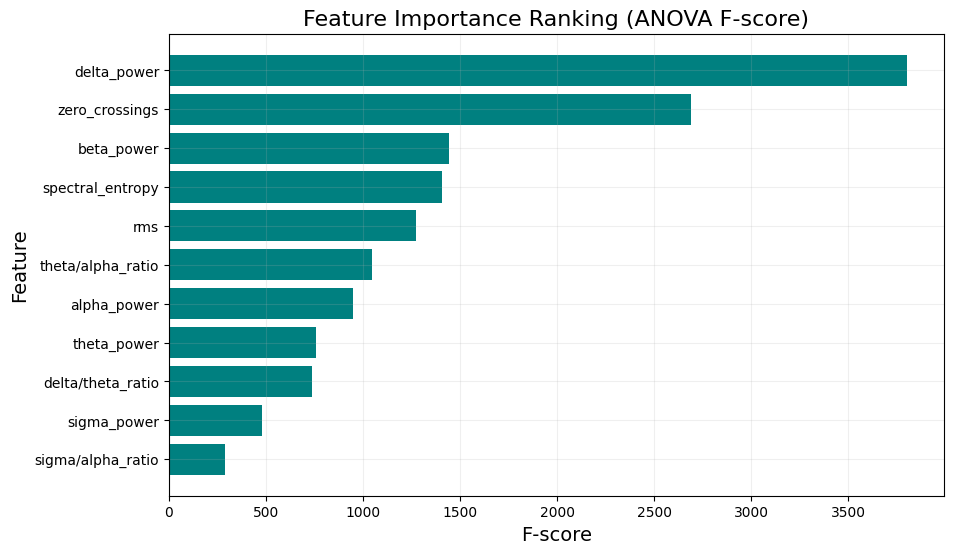

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(df_sorted['Feature'], df_sorted['ANOVA_F_score'], color='teal')
plt.gca().invert_yaxis()
plt.title("Feature Importance Ranking (ANOVA F-score)", fontsize=16)
plt.xlabel("F-score", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.grid(alpha=0.2)
plt.show()


In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_test_scaled  = scaler.transform(X_test_feat)

print("Scaled feature shapes:", X_train_scaled.shape, X_test_scaled.shape)


Scaled feature shapes: (16057, 11) (4546, 11)


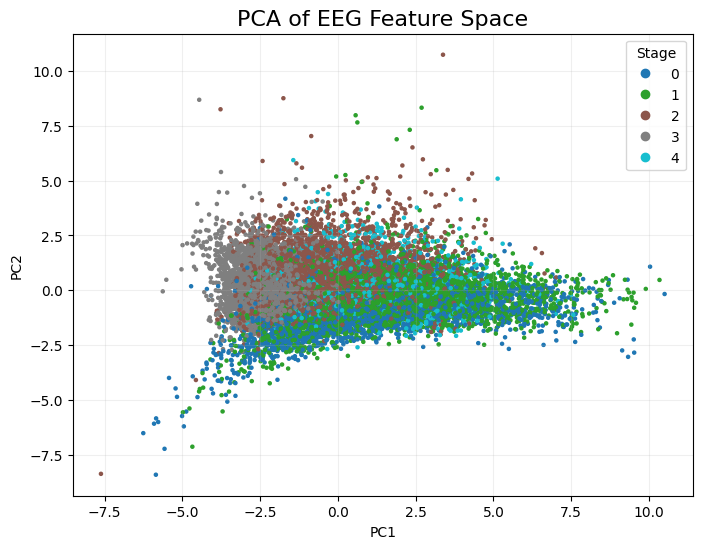

In [48]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y_train, cmap='tab10', s=5)
plt.title("PCA of EEG Feature Space", fontsize=16)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.2)
plt.legend(*scatter.legend_elements(), title="Stage")
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


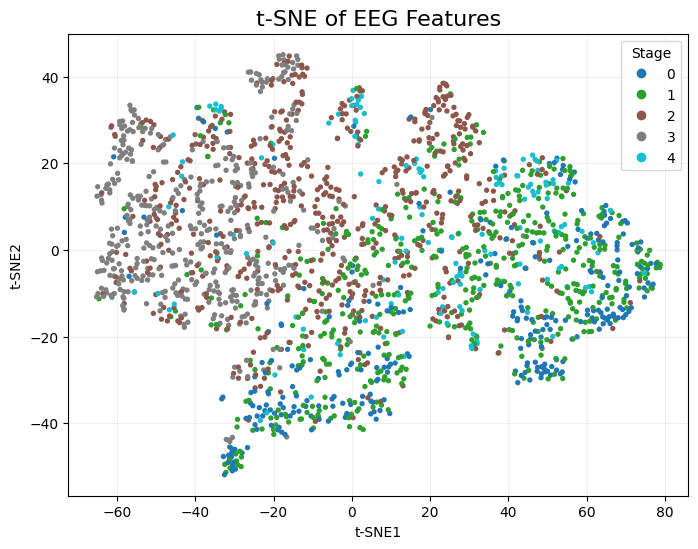

In [49]:
from sklearn.manifold import TSNE

idx = np.random.choice(len(X_train_scaled), size=2000, replace=False)

X_sample = X_train_scaled[idx]
y_sample = y_train[idx]

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1500)
X_tsne = tsne.fit_transform(X_sample)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y_sample, cmap='tab10', s=8)
plt.title("t-SNE of EEG Features", fontsize=16)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.grid(alpha=0.2)
plt.legend(*scatter.legend_elements(), title="Stage")
plt.show()


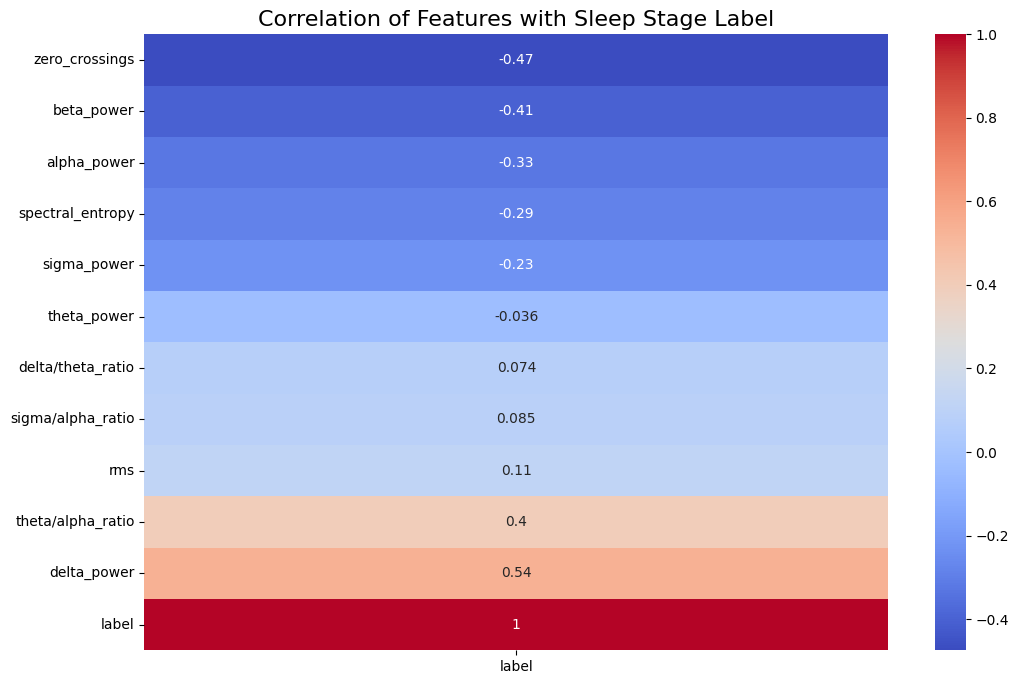

In [50]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame(X_train_feat, columns=feature_names)
df['label'] = y_train

corr = df.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr[['label']].sort_values('label'), annot=True, cmap='coolwarm')
plt.title("Correlation of Features with Sleep Stage Label", fontsize=16)
plt.show()


In [51]:
!pip freeze > requirementss.txt
